# CIFAR10 분류를 위한 VGGNet 모델 학습

VGG-16 : 13 convolutional layers, 3 fully conncected layers

Filter size = 3x3 Stride = 1 Padding = 1

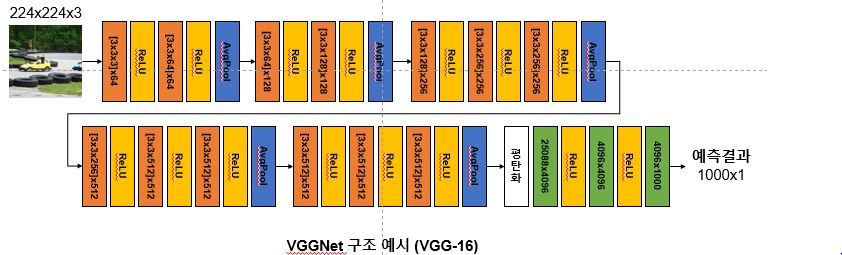

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 폴더 경로 저장

In [4]:
datasetPath = "./drive/MyDrive/dataset/"
parameterPath = "./drive/MyDrive/parameters"

### 패키지 선언

In [5]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import numpy as np

### 데이터셋 선언

In [6]:
# Training dataset 다운로드
cifar10_train = dataset.CIFAR10(root = datasetPath,
                            train = True, # train 데이터셋이면 true
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar10_test = dataset.CIFAR10(root = datasetPath,
                           train = False, # train 데이터셋이 아닌(test 데이터셋이면) false
                           transform = transform.ToTensor(),
                           download = True)

Files already downloaded and verified
Files already downloaded and verified


50000
torch.Size([3, 32, 32])
6


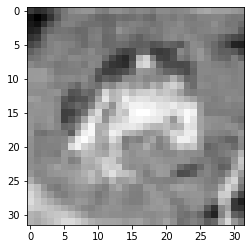

In [7]:
# CIFAR10 데이터셋 형상 확인
import matplotlib.pyplot as plt
print(len(cifar10_train)) #train 데이터셋 개수 확인 : 6만개

first_data = cifar10_train[0] 
print(first_data[0].shape)  # 첫번째 data의 형상 확인 - 데이터 이미지 (3x32x32pixels)
print(first_data[1])        # 첫번째 data의 정답 확인 - 데이터 값(숫자) (5)

plt.imshow(first_data[0][0,:,:], cmap = 'gray')
plt.show()

## CNN 모델 정의

**Conv2d : Convolution layer**

torch.nn.Conv2d(***in_channels***, ***out_channels***, ***kernel_size***, **stride=1**, **padding=0**, dilation=1,groups=1,bias=True,padding_mode='zeros',device=None,dtype=None)

**Linear : Fully connected layer**

torch.nn.Linear(***in_features***, ***out_features***, bias=True,device=None, dype=None)

**ReLU : Activation Function**

torch.nn.ReLU(inplace=False)

**MaxPool2d : Pooling layer**

torch.nn.MaxPool2d(**kernel_size**, **stride=None**, padding=0, dilation=1 return_indices=False,ceil_mode=False)

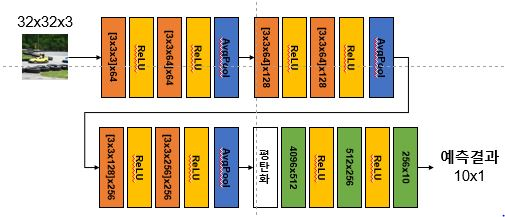

28x28x**1** -conv1[5x5x**1**]x**6**->  24x24x**6**

In [8]:
class VGG (nn.Module):
  def __init__(self): # Parameter를 가지는 lalyer 정보
    super(VGG, self).__init__()  #자기 자신을 또 부름
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(in_features=4096, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=10)
    self.relu = nn.ReLU()
    self.avgPool2d = nn.AvgPool2d(kernel_size=2, stride=2)  # ReLU, Pooling layer는 parameter를 안 가짐

  def forward(self, x):  # 모델의 동작 순서, 각 layer & function의 입출력 관계
    out = self.relu(self.conv1(x))
    out = self.relu(self.conv2(out))
    out = self.avgPool2d(out)
    out = self.relu(self.conv3(out))
    # out = self.relu(self.conv3(out))
    out = self.avgPool2d(out)
    out = self.relu(self.conv4(out))
    out = self.relu(self.conv5(out))
    out = self.avgPool2d(out)

    out = out.view(-1, 4096) # feature map 평탄화
    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)
    return out

### Hyper-parameters 지정

In [15]:
batch_size = 100
learning_rate = 0.1
training_epoch = 20
loss_function = nn.CrossEntropyLoss()
network = VGG()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)

data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

In [16]:
!nvidia-smi

Wed May 18 11:37:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   1616MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Network Training

In [17]:
network = network.to('cuda:0')
for epoch in range(training_epoch):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:

      img = img.to('cuda:0')
      label = label.to('cuda:0')

      pred = network(img)

      loss = loss_function(pred, label) # 입력 이미지에 대해 forward pass
      optimizer.zero_grad() # gradient(기울기) 초기화 # 예측 값, 정답을 이용해 loss 계산
      loss.backward() #back propagation # 모든 weight에 대해 편미분 값 계산
      optimizer.step()  # 파라미터 업데이트

      avg_cost += loss / total_batch
      
  print('Epoch: %d Loss = %f' %(epoch + 1, avg_cost))

print('Learning finished')


Epoch: 1 Loss = 2.300671
Epoch: 2 Loss = 2.083266
Epoch: 3 Loss = 1.882911
Epoch: 4 Loss = 1.715741


weight parameter 저장

In [18]:
torch.save(network.state_dict(), parameterPath+"VGGNet_cifar10.pth")

CIFAR10 Test dataset 분류 성능 확인

In [19]:
with torch.no_grad(): # test에서는 기울기 계산 제외
  
  img_test = cifar10_test.data.float().unsqueeze(1) # 새로운 차원(channel) 추가 
  # [Batch x Channel x Height x Width] eff10000 x 28 x 28 -> 10000 x 1 x 28 x 28
  label_test = cifar10_test.targets

  prediction = network(img_test)  # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print("Accuracy:", accuracy.item())

AttributeError: ignored

In [20]:
network.eval()
network = network.to('cpu')
img_test = torch.tensor(np.transpose(cifar10_test.data , (0, 3, 1, 2))) /255.
label_test = torch.tensor(cifar10_test.targets)

with torch.no_grad(): # test에서는 기울기 계산 제외
    prediction = network(img_test) # 전체 test data를 한번에 계산

correct_prediction = torch.argmax(prediction, 1) == label_test
accuracy = correct_prediction.float().mean()
print('Accuracy:', accuracy.item())

Accuracy: 0.635699987411499
